# Gaussian Process Emulation of the Deterministic BusSim Model

This notebook extends the work from the previous notebook ([Exploration.ipynb](./Exploration.ipynb)), moving from the deterministic `BusSim` model to the stochastic one.
The stochastic `BusSim` model introduces random variation into the number of passengers who want to board the bus at each stop - it is now a Poisson process rather than a constant rate.

This poses an interesting challenge for model emulation.
We could now conceivably have different outputs from the model for the same inputs.
In this notebook, we will explore ways in which we can still use a GP to emulate this type of system.

## Aims

- Explore the impact of changing traffic speed on the stochastic bus model
- Fit a GP emulator to the model and investigate different ways of handling the stochasticity
- Evaluate the quality of the GP emulator
- Discuss potential extensions to these approaches

In [1]:
from BusSim_stochastic import run_model as run_model_s
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import mogp_emulator

# Increase default figure size
plt.rcParams["figure.figsize"] = [12, 6]
plt.rcParams["font.size"] = 16

np.random.seed(0)  # for reproducibility, if running entire notebook from the beginning

## Set up the model

We will move fairly quickly through this section as it is rather similar to the analogous section in the notebook that describes the deterministic case.

First, we set up a function to interface with the original `BusSim` code.

In [2]:
def run_stochastic_model(ArrivalRate=None, TrafficSpeed=14, bus_ids_out=[0, 1, 2], maxDemand=2, DEBUG=False):
    
    NumberOfStop = 20
    minDemand = 0.5
     
    # Initialise the remaining model parameters
    model_params = {
        "dt": 10,
        "minDemand": minDemand,        
        "NumberOfStop": NumberOfStop,
        "LengthBetweenStop": 2000,
        "EndTime": 6000,
        "Headway": 5 * 60,
        "BurnIn": 1 * 60,
        "AlightTime": 1,
        "BoardTime": 3,
        "StoppingTime": 3,
        "BusAcceleration": 3
    }
    
    if ArrivalRate is None:
        ArrivalRate = np.random.uniform(minDemand / 60, maxDemand / 60, NumberOfStop) 
    else:
        ArrivalRate = ArrivalRate * np.ones(NumberOfStop)
        
    DepartureRate = np.sort(np.random.uniform(0.05, 0.5, NumberOfStop)) # Sorted as more passengers get off near the end of the route

    model, model_params, ArrivalData, StateData, GroundTruth, GPSData = \
        run_model_s(model_params, TrafficSpeed, ArrivalRate, DepartureRate, False, False, False, True)
            
    bus_pos = np.array([bus.trajectory for bus in model.buses])    
    time = np.arange(0, model.EndTime, model.dt)
    total_distance = model_params["NumberOfStop"] * model_params["LengthBetweenStop"]

    bus_t_end = [time[np.argmax(bp>=total_distance)] for bp in bus_pos]
    bus_end_times = [bus_t_end[id] for id in bus_ids_out]
    
    if DEBUG:
        print(bus_t_end)
    
    return bus_end_times, GPSData

## Initial look at variation

We'll start by taking a look at the variability in bus arrival times for two different values of traffic speed.
This will let us see how much variability arises from the model's stochasticity as opposed to the traffic speed parameter.

In [3]:
%%capture
bus_ids = range(8)
repeats = 10

md = 6
ts = 14
ts_fast = 28

end_times = np.zeros((len(bus_ids), repeats))
gps_locs = []
for r in range(repeats):
    t, g = run_stochastic_model(TrafficSpeed=ts, bus_ids_out=bus_ids, maxDemand=md)
    end_times[:,r] = t
    gps_locs.append(g)
    
end_times_fast = np.zeros((len(bus_ids), repeats))
gps_locs_fast = []
for r in range(repeats):
    t, g = run_stochastic_model(TrafficSpeed=ts_fast, bus_ids_out=bus_ids, maxDemand=md)
    end_times_fast[:,r] = t
    gps_locs_fast.append(g)

First let's check out what happens with the default speed of 14.

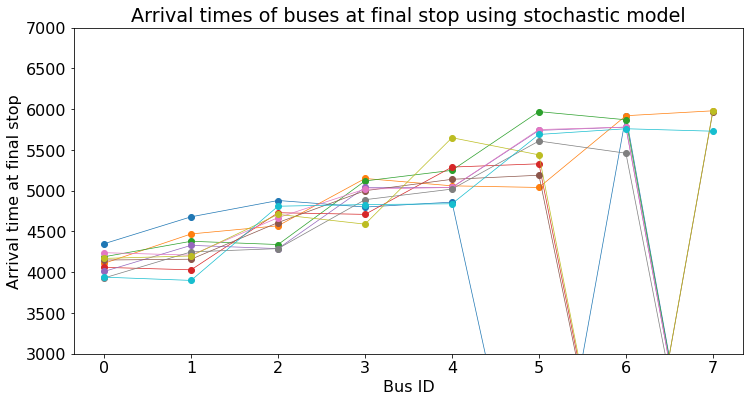

In [4]:
plt.plot(bus_ids, end_times, marker="o", linestyle="-", linewidth=0.7)
plt.ylim((3000, 7000))
plt.xlabel("Bus ID")
plt.ylabel("Arrival time at final stop")
plt.title("Arrival times of buses at final stop using stochastic model");

In the plot above, we can see that the introduction of stocasticity causes changes in the arrival time which are appreciable (although not large) when compared to the value of the arrival time itself.

Simulations contain a mix of "early" and "late" buses, and we note that some of the buses that depart later do not reach their final stop within the simulated time period.

We will also compare those buses against others travelling at a much faster speed.
We have dropped colours for clarity in the next; slow buses (with the default speed of 14) are shown in black and fast ones in blue.

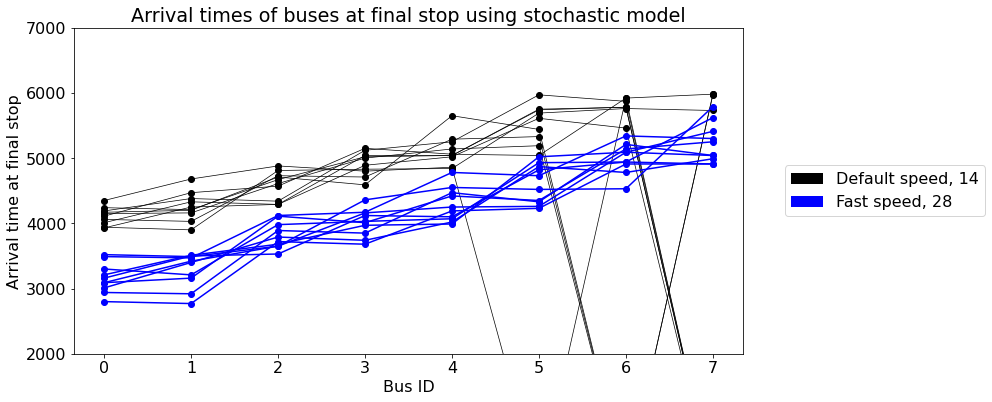

In [5]:
plt.plot(bus_ids, end_times, color="k", marker="o", linestyle="-", linewidth=0.7);
plt.plot(bus_ids, end_times_fast, color="b", marker="o", linestyle="-");
plt.ylim((2000, 7000));
plt.xlabel("Bus ID");
plt.ylabel("Arrival time at final stop")
plt.title("Arrival times of buses at final stop using stochastic model")
plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5),
           handles=[matplotlib.patches.Patch(facecolor="k", edgecolor=None, label="Default speed, {}".format(ts)),
                    matplotlib.patches.Patch(facecolor="b", edgecolor=None, label="Fast speed, {}".format(ts_fast))]);

## Using a GP to emulate bus arrival times with variable traffic speed

Before we start, what might we expect to see as an output from the GP this time?

In the previous notebook, we used a GP to predict final arrival times for different traffic speeds.
That GP generally showed very low uncertainty, apart from at the limits of the traffic speed parameter space and sometimes also for Bus 0, which was often overtaken by the bus that followed it when the traffic speeds were higher.

### Generate training data for the GP

We'll consider the same set-up as last time: we will vary traffic speed between 15 and 50.
The difference this time is that we will run repeated simulations at each of those training points, so that we have `n_repeats` (by default here, 5) repeats per value of traffic speed.

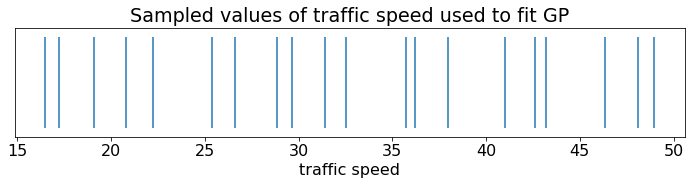

In [6]:
ts_bus_ids = [0, 1, 2, 3, 6, 9]

lhd = mogp_emulator.LatinHypercubeDesign([(15.0, 50.0)])

n_simulations = 20
n_repeats = 5
n_sims = n_simulations * n_repeats
lhd_traffic_speeds = lhd.sample(n_simulations)

plt.figure(figsize=[12, 2])
plt.eventplot(lhd_traffic_speeds[:,0], lineoffsets=1)
plt.ylim((0.4,1.6))
plt.yticks([])
plt.xlabel("traffic speed")
plt.title("Sampled values of traffic speed used to fit GP");

# Now modify the array so that repeated values are included
lhd_traffic_speeds = np.repeat(lhd_traffic_speeds, n_repeats)

In [7]:
%%capture

ts_simulation_output = np.zeros((len(ts_bus_ids), n_sims))

for ind, ts in enumerate(lhd_traffic_speeds):
    sim_out, _ = run_stochastic_model(TrafficSpeed=ts, bus_ids_out=ts_bus_ids)
    ts_simulation_output[:,ind] = np.array(sim_out)

### Fit the GP

We'll actually fit several different models here to try out the effects of changing the kernel.

For a more thorough introduction to the various options available for kernels, see Murphy's [“Probabilistic Machine Learning: An Introduction”]( https://probml.github.io/pml-book/) (2021 edition).
Briefly, the two kernels we consider here are Mercer kernels (or positive definite kernels, where the Gram matrix is positive definite for a set of distinct inputs).

When we make a prediction via a GP emulator, we need a measure of how similar our input is to the existing input values, as our output will be a weighted combination of the existing inputs.
To determine the weights, we need a similarity metric - this is known as a kernel.

The squared exponential kernel is one of the most commonly used:
  $$ \mathcal{K}(\mathbf{x}, \mathbf{x'}) = \exp \left( - \frac{|| \mathbf{x} - \mathbf{x'} ||^2}{2\ell^2}\right)$$
There is one hyperparameter, the lengthscale or bandwidth, $\ell$.
For new input $\mathbf{x'}$ which is similar to $\mathbf{x}$, the value of $\mathcal{K}(\mathbf{x}, \mathbf{x'})$ will also be large, so the predicted output will be heavily weighted towards that of $\mathbf{x}$.

We also consider Matern kernels, which give rise to functions which are less smooth than the squared exponential (which is infinitely differentiable).

They have two hyperparameters: $\nu$ (from Bessel function order) and $\ell$.
- $\nu=1/2$ gives velocity of a particle undergoing Brownian motion, which yields a very jagged function
- Higher $\nu$ values give smoother functions

We will use the 5/2 Matern kernel, as it produces functions that are less smooth than the (default) squared exponential.
Therefore, it may be better at capturing the variability in arrival times.
    
There are still further kernels available, some of which cater for more specific cases such as periodic functions.
In addition to the book recommended above, Duvenaud's [Kernel Cookbook](https://www.cs.toronto.edu/~duvenaud/cookbook/) is another useful resource on kernel choice for GPs.

For each kernel, we fit two GPs.
This is to let us investigate the effect of the nugget, which is a small term added to the diagonal of the covariance matrix.
Normally, this would help improve the efficiency of the covariance matrix inversion, but the nugget can also be used as a proxy for a small amount of stochastic variation in the simulation.

The two options that we try are `adaptive`, where the value of the nugget is increased over again until the system can be solved, and `fit`, where the value of the nugget is treated as a hyperparameter which should be fully optimised.
These options (along with alternatives) are discussed in the documentation of the `mogp_emulator` package: see [nugget definition](https://mogp-emulator.readthedocs.io/en/latest/methods/def/DefNugget.html) and notes on its [implementation](https://mogp-emulator.readthedocs.io/en/latest/implementation/GaussianProcess.html#gaussianprocess) in the `GaussianProcess` class.

In [8]:
ts_gp_se = mogp_emulator.MultiOutputGP(lhd_traffic_speeds, ts_simulation_output, kernel=mogp_emulator.Kernel.SquaredExponential(), nugget="adaptive")
ts_gp_se = mogp_emulator.fit_GP_MAP(ts_gp_se)

ts_gp_se_nfit = mogp_emulator.MultiOutputGP(lhd_traffic_speeds, ts_simulation_output, kernel=mogp_emulator.Kernel.SquaredExponential(), nugget="fit")
ts_gp_se_nfit = mogp_emulator.fit_GP_MAP(ts_gp_se_nfit)

ts_gp_m52 = mogp_emulator.MultiOutputGP(lhd_traffic_speeds, ts_simulation_output, kernel=mogp_emulator.Kernel.Matern52(), nugget="adaptive")
ts_gp_m52 = mogp_emulator.fit_GP_MAP(ts_gp_m52)

ts_gp_m52_nfit = mogp_emulator.MultiOutputGP(lhd_traffic_speeds, ts_simulation_output, kernel=mogp_emulator.Kernel.Matern52(), nugget="fit")
ts_gp_m52_nfit = mogp_emulator.fit_GP_MAP(ts_gp_m52_nfit)

We will see some warnings with the following message as we run the code above: `Matrix not positive definite, skipping this iteration`

This is generated because there are different values of the final arrival time for the same input value of traffic speed.

### Try out the GP

We will now make some predictions from each of our trained Gaussian Process emulators.

We set the `include_nugget` option to `False` below so that the nugget is not included in our uncertainty bounds.

In [9]:
%%capture
n_validation = 50

validation_traffic_speeds = lhd.sample(n_validation)

nugget_setting = False

# Generate a set of predictions from each of out GP emulators
predicted_ts_se = ts_gp_se.predict(validation_traffic_speeds, include_nugget=nugget_setting)
predicted_ts_se_nfit = ts_gp_se_nfit.predict(validation_traffic_speeds, include_nugget=nugget_setting)
predicted_ts_m52 = ts_gp_m52.predict(validation_traffic_speeds, include_nugget=nugget_setting)
predicted_ts_m52_nfit = ts_gp_m52_nfit.predict(validation_traffic_speeds, include_nugget=nugget_setting)

# Perform simulations based on the same input values
actual_ts = np.zeros((len(ts_bus_ids), n_validation))
for ind, ts in enumerate(validation_traffic_speeds):
    sim_out, _ = run_stochastic_model(TrafficSpeed=ts[0], bus_ids_out=ts_bus_ids)
    actual_ts[:,ind] = np.array(sim_out)

In [10]:
# Define a function for plotting data used to train a gp, the simulated outputs and emulated outputs
def plot_gp_train_and_pred(train_inputs, test_inputs, train_outputs, simulated_outputs, predicted_outputs, bus_ids, plt_bus_index=None):
    
    # Set the markers used in the plot
    plt_mk = { "train": ".",      # Used to train the GP
               "pred": "x",       # Predicted by the GP
               "sim": "+" }       # Same TS as "pred", full simulation
    plt_mk_legend = [matplotlib.lines.Line2D([0], [0], marker=plt_mk["train"], color="w", label="Training",
                     markerfacecolor="k", markeredgecolor="k"), 
                     matplotlib.lines.Line2D([0], [0], marker=plt_mk["pred"], color="w", label="Predicted (GP)",
                     markerfacecolor="k", markeredgecolor="k"),
                     matplotlib.lines.Line2D([0], [0], marker=plt_mk["sim"], color="w", label="Simulated",
                     markerfacecolor="k", markeredgecolor="k")]
    
    legend_entries = []

    # Easier to look at one bus at a time
    if plt_bus_index:
        plt.title("Bus {}".format(bus_ids[plt_bus_index]))

    for ind, (a, p, u) in enumerate(zip(simulated_outputs, predicted_outputs.mean, predicted_outputs.unc)):

        if plt_bus_index is None or ind == plt_bus_index:
            plt.plot(test_inputs, a, marker=plt_mk["sim"], linestyle="", color=plt.cm.Set1(ind))
            plt.plot(test_inputs, p, marker=plt_mk["pred"], linestyle="", color=plt.cm.Set1(ind))
            plt.plot(train_inputs, train_outputs[ind,], marker=plt_mk["train"], linestyle="", color=plt.cm.Set1(ind))

            legend_entries.append(matplotlib.patches.Patch(facecolor=plt.cm.Set1(ind), edgecolor=None, label="Bus {}".format(bus_ids[ind])))

            o = np.argsort(validation_traffic_speeds, axis=None)
            plt.fill_between(validation_traffic_speeds.flatten()[o], p[o]-u[o], p[o]+u[o],
                             color=plt.cm.Set1(ind), alpha=0.2, linewidth=0)

    plt.xlabel("Traffic speed")
    plt.ylabel("Time at final\ndestination")
    plt.legend(handles=legend_entries+plt_mk_legend, fontsize="small", loc="center right", bbox_to_anchor=(1.3,0.5))
    plt.ylim((0, 8000))

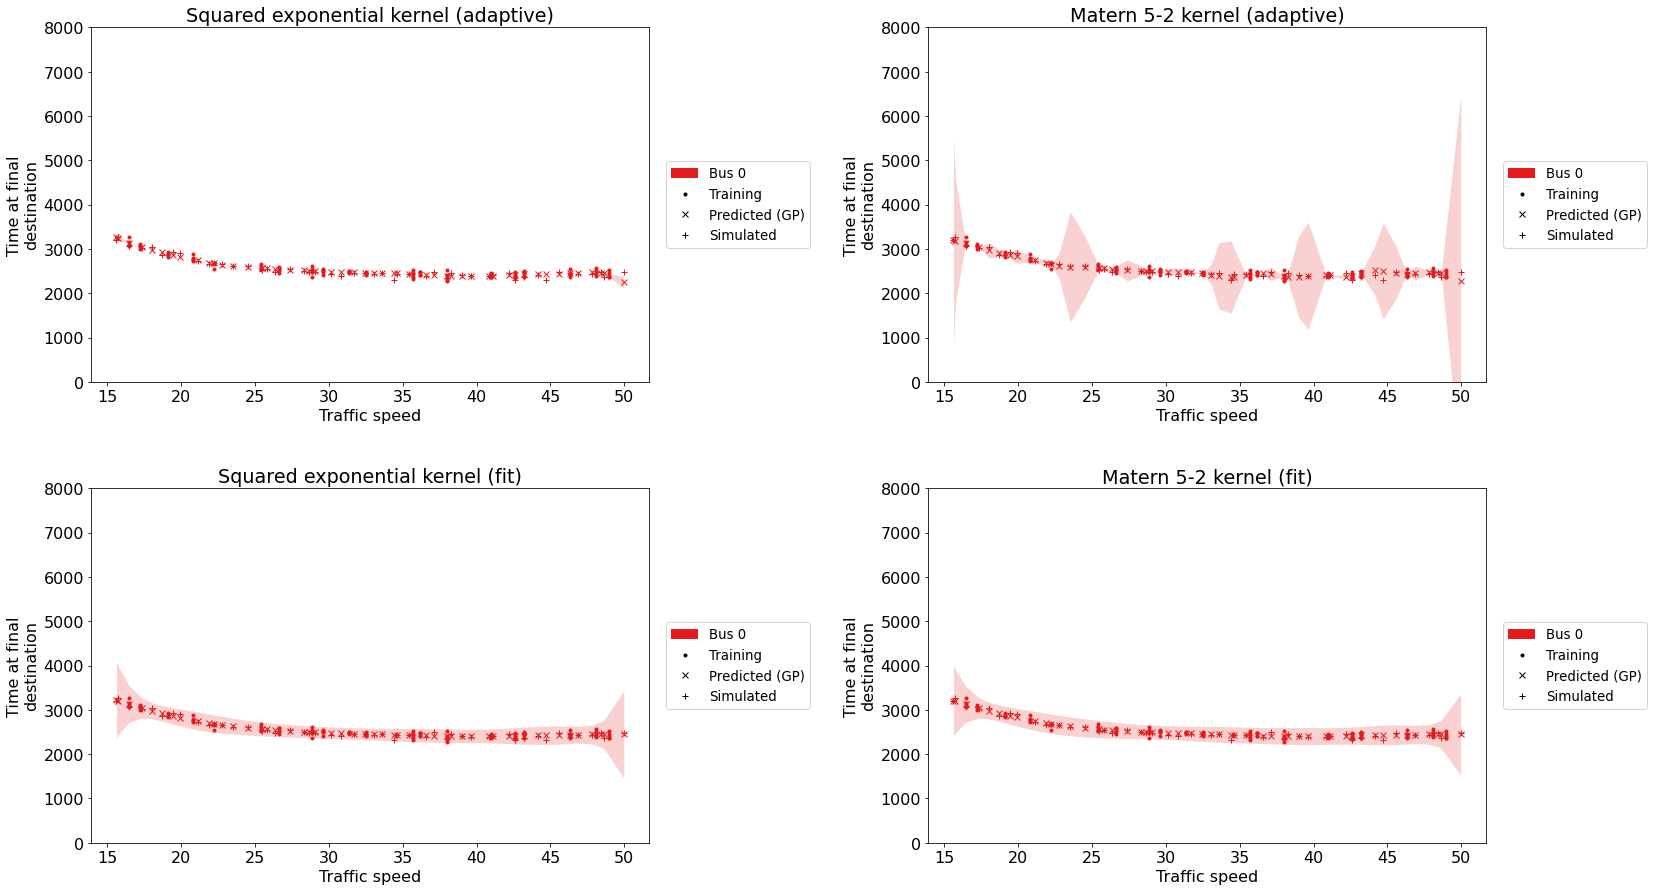

In [11]:
plt_bus_index = 0  # Change to examine GP emulator for different buses

fig, axs = plt.subplots(2,2,figsize=(25,15))
fig.subplots_adjust(wspace=0.5, hspace=0.3)

plt.sca(axs[0,0])
plot_gp_train_and_pred(lhd_traffic_speeds, validation_traffic_speeds, 
                      ts_simulation_output, actual_ts, predicted_ts_se, ts_bus_ids, plt_bus_index);
plt.title("Squared exponential kernel (adaptive)");

plt.sca(axs[1,0])
plot_gp_train_and_pred(lhd_traffic_speeds, validation_traffic_speeds, 
                      ts_simulation_output, actual_ts, predicted_ts_se_nfit, ts_bus_ids, plt_bus_index);
plt.title("Squared exponential kernel (fit)");

plt.sca(axs[0,1])
plot_gp_train_and_pred(lhd_traffic_speeds, validation_traffic_speeds, 
                      ts_simulation_output, actual_ts, predicted_ts_m52, ts_bus_ids, plt_bus_index);
plt.title("Matern 5-2 kernel (adaptive)");

plt.sca(axs[1,1])
plot_gp_train_and_pred(lhd_traffic_speeds, validation_traffic_speeds, 
                      ts_simulation_output, actual_ts, predicted_ts_m52_nfit, ts_bus_ids, plt_bus_index);
plt.title("Matern 5-2 kernel (fit)");

In this task, the squared exponential and Matern kernels seem to perform relatively comparably, with the larger differences being due to the nugget choice.

As expected, the Matern kernel does better capture sharp changes in uncertainty in the predictions where there are gaps in the training points, but these uncertainties do generally seem higher than necessary.

Optimising the nugget using the `fit` method yields uncertainties comparable with the variation from the model's overall trend, so this approach seems to be working well.

### Investigate the nugget parameter (adaptive or fit)

In [12]:
print("Traffic speed emulator with squared exponential kernel and adaptive nugget")
for bus, em in zip(ts_bus_ids, ts_gp_se.emulators):
    print("Bus {}\t{}\t({})".format(bus, em.nugget, em.nugget_type))

print("\nTraffic speed emulator with squared exponential kernel and fit nugget")
for bus, em in zip(ts_bus_ids, ts_gp_se_nfit.emulators):
    print("Bus {}\t{}\t({})".format(bus, em.nugget, em.nugget_type))
    
print("\nTraffic speed emulator with Matern 5-2 kernel and adaptive nugget")
for bus, em in zip(ts_bus_ids, ts_gp_m52.emulators):
    print("Bus {}\t{}\t({})".format(bus, em.nugget, em.nugget_type))
    
print("\nTraffic speed emulator with Matern 5-2 kernel and fit nugget")
for bus, em in zip(ts_bus_ids, ts_gp_m52_nfit.emulators):
    print("Bus {}\t{}\t({})".format(bus, em.nugget, em.nugget_type))

Traffic speed emulator with squared exponential kernel and adaptive nugget
Bus 0	19.274214565359603	(adaptive)
Bus 1	4.28712097786937	(adaptive)
Bus 2	5.185165056421789	(adaptive)
Bus 3	5.325990502285086	(adaptive)
Bus 6	54.92710493046882	(adaptive)
Bus 9	15.202965308210928	(adaptive)

Traffic speed emulator with squared exponential kernel and fit nugget
Bus 0	3486.892240074797	(fit)
Bus 1	10057.146809378854	(fit)
Bus 2	13902.359068807658	(fit)
Bus 3	14373.724318001037	(fit)
Bus 6	14977.81571313768	(fit)
Bus 9	323510.12373831606	(fit)

Traffic speed emulator with Matern 5-2 kernel and adaptive nugget
Bus 0	3.6389023207513684	(adaptive)
Bus 1	24.666277986076178	(adaptive)
Bus 2	5.90499729621493	(adaptive)
Bus 3	7.230069539610714	(adaptive)
Bus 6	11.937466012055184	(adaptive)
Bus 9	23.82788819229816	(adaptive)

Traffic speed emulator with Matern 5-2 kernel and fit nugget
Bus 0	3491.1661838939103	(fit)
Bus 1	10043.09927956467	(fit)
Bus 2	13890.502291038374	(fit)
Bus 3	13219.040365588116	(

## Accuracy of the uncertainty estimate

With the `include_nugget` option turned off, we get much more reasonable results from the GP emulators than if it was set to `True`. (Can test this out above by changing the `nugget_setting` variable.)

Now let's get try to understand how well the uncertainty in the model is quantified, by adding further simulation runs to the above plot.

In [13]:
%%capture
n_validation_repeats = 10

further_ts = np.zeros((len(ts_bus_ids), n_validation, n_validation_repeats))
for ind, ts in enumerate(validation_traffic_speeds):
    for ind_rep in range(n_validation_repeats):
        sim_out, _ = run_stochastic_model(TrafficSpeed=ts[0], bus_ids_out=ts_bus_ids)
        further_ts[:,ind,ind_rep] = np.array(sim_out)  # dim: bus_ind, validation ts, repeat

In [14]:
# Define a function for plotting data used to train a gp, the simulated outputs and emulated outputs
def plot_gp_and_sims(inputs, simulated_outputs, predicted_outputs, bus_ids, plt_bus_index=None):
    
    legend_entries = []
    
    input_order = np.argsort(inputs, axis=None)

    # Easier to look at one bus at a time
    if plt_bus_index:
        plt.title("Bus {}".format(bus_ids[plt_bus_index]))

    for ind, (a, p, u) in enumerate(zip(simulated_outputs, predicted_outputs.mean, predicted_outputs.unc)):

        if plt_bus_index is None or ind == plt_bus_index:
            plt.plot(inputs[input_order], p[input_order], marker="", linestyle="-", color=plt.cm.Set1(ind))
            
            plt.fill_between(inputs.flatten()[input_order], p[input_order]-u[input_order], p[input_order]+u[input_order],
                             color=plt.cm.Set1(ind), alpha=0.2, linewidth=0)
            
            for inp, sim in zip(inputs, simulated_outputs[plt_bus_index]):
                plt.scatter(inp*np.ones((len(sim),1)), sim, marker=".", color="k", s=5)
                sim_std = np.std(sim)
                sim_mean = np.mean(sim)
                plt.scatter([inp, inp], sim_mean+[-2*sim_std, 2*sim_std], marker="_", color="k", s=50)

    plt.xlabel("Traffic speed")
    plt.ylabel("Time at final\ndestination")
    plt.ylim((0, 8000))

In [15]:
# Create a dict of options to make the following plot easier to generate
plt_gps = {"sead": {"preds": predicted_ts_se, "title": "Squared exponential kernel, adaptive nugget"},
           "sefit": {"preds": predicted_ts_se_nfit, "title": "Squared exponential, fit nugget"},
           "m52ad": {"preds": predicted_ts_m52, "title": "Matern 5/2 kernel, adaptive nugget"},
           "m52fit": {"preds": predicted_ts_m52_nfit, "title": "Matern 5/2 kernel, fit nugget"}}

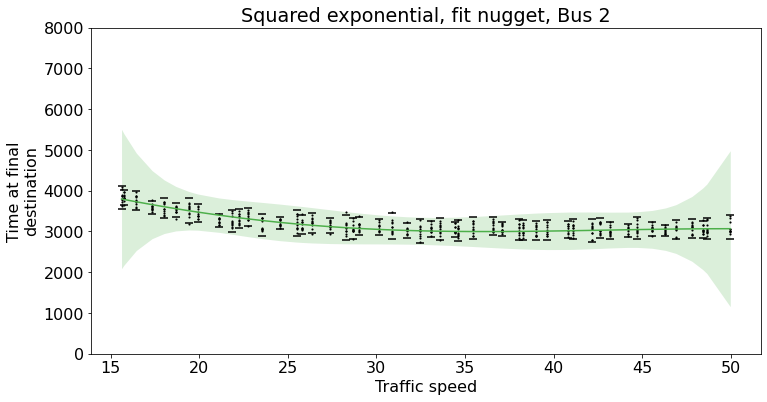

In [16]:
plt_bus_index = 2
plt_gp = "sefit"    # change to one of the keys in the dict above to switch between different GP emulators

plot_gp_and_sims(validation_traffic_speeds, further_ts, plt_gps[plt_gp]["preds"], ts_bus_ids, plt_bus_index)
plt.title("{}, Bus {}".format(plt_gps[plt_gp]["title"], ts_bus_ids[plt_bus_index]));

The plot above shows how the predictions and uncertainties from each GP emulator compare with the outputs of several repeated simulations at the same value of traffic speed. The horizontal bars show the mean plus/minus two standard deviations of the simulated outputs.

As we noted from the initial plots, the GP emulators where the nugget was fit show uncertainty bounds far more in keeping with the stochastic variation of the model than the adaptive nuggets do.
However, the uncertainty bounds are larger for the final buses (try e.g. `plt_bus_index=5`, `plt_gp="sefit"`).
This is potentially due to some of the final buses not arriving at their destination before the end of the simulation, yet the uncertainty remains high even for speeds when all buses do reach that final stop.
The nugget values (printed several cells above) are of the order of 10x greater for these bus/emulator combinations, which means we should seek to understand this further before adding to the complexity of the system we seek to emulate.

## Potential extensions

In this notebook we have investigated an accessible method for implementing Gaussian Process emulation for stochastic systems.
The treatment of the stochastic term is relatively simple here, and will not allow for detailed capture of stochasticity that is, for example, dependent on other model parameters.

At the time of writing, software packages for GP emulation were lacking this feature, however, several approaches have been proposed.
A natural extension of the work above would be to implement one or more of these type of approaches in the `mogp_emulator` package, and see how the GP emulator's performance is affected. 
A good starting point would be _Managing Uncertainty in Complex Stochastic Models: Design and Emulation of a Rabies Model_, Boukouvalas _et al._ (2009, preprint available [here](https://www.mucm.ac.uk/Pages/Downloads/Technical%20Reports/08-06.pdf)) which builds upon prior work ([Kersting _et al._, 2007](https://people.csail.mit.edu/kersting/papers/kersting07icml_mlHetGP.pdf)) to emulate the stochastic term using an additional GP emulator.